# Hourly PSDS - IROMY | WROMY | ROMY

## Load Libraries

In [1]:
from obspy import UTCDateTime
from scipy.signal import welch
from numpy import log10, zeros, pi, append, linspace, mean, median, array, where, transpose, shape, histogram, arange, append
from numpy import logspace, linspace, log, log10, isinf, ones, nan, count_nonzero, sqrt, isnan
from pandas import DataFrame, concat, Series, date_range, read_csv, read_pickle
from tqdm import tqdm
from pathlib import Path

import os, sys
import pickle
import matplotlib.pyplot as plt

from andbro__store_as_pickle import __store_as_pickle

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

## Configurations

In [3]:
## ---------------------------------------

# name, comp, app = "PROMY", "", ""
name, comp, app = "FFBI", "", "_absolute"
# name, comp, app  = "ROMY", "Z", ""
# name, comp, app = "ROMY", "U", ""
# name, comp, app = "ROMY", "V", ""

year = "2023"

path = data_path+f"LNM2/PSDS/"

t1 ,t2 = "2023-09-23", "2023-10-23"

In [8]:
## ---------------------------------------

## load configurations
if len(comp) != 0:
    config = pickle.load(open(path+name+app+"/"+f"{year}_{name}_{comp}_3600_config.pkl", 'rb'))
    config['filename'] = f"{name}{app}/{year}_{name}_{comp}_3600"
    config['station'] = f"{name}_{comp}"
else:
    config = pickle.load(open(path+name+app+"/"+f"{year}_{name}_3600_config.pkl", 'rb'))
    config['filename'] = f"{name}{app}/{year}_{name}_3600"
    config['station'] = f"{name}"


config['path'] = path

config['startdate'], config['enddate'] = t1, t2



## specify paths
config['outpath_figures'] = data_path+f"LNM2/figures/"

config['path_to_outdata'] = data_path+f"LNM2/data/"

## Methods

In [9]:
def __load_data_file(path, file):

    from tqdm.notebook import tqdm
    from numpy import array

    psds_all = []
    psds_hourly = read_pickle(path+file)

    for psd in psds_hourly:
        psds_all.append(psd)

    return array(psds_all)

In [10]:
!ls /import/kilauea-data/LNM2/PSDS/

DINO	       FFBI_absolute_MT  FURT	PROMY  WROMY	  WROMY_WS7
FFBI_absolute  FFBI_infrasound	 IROMY	ROMY   WROMY_WS1


## Compute PSD value per frequency band

In [11]:
d1, d2 = config['startdate'], config['enddate']

psds_medians_out, times_out = [], []

ff = pickle.load(open(config['path']+f"{config['filename']}_frequency_axis.pkl", 'rb'))

dat, dates = [], []
for jj, day in enumerate(date_range(d1, d2)):

    # if jj > 2:
    #     continue

    day = str(day).split(" ")[0].replace("-", "")

    print(day)

    config['outpath_figname'] = "joint_IROMY_"+day

    try:
        _dat = __load_data_file(path,f"{config['filename']}_{day}_hourly.pkl")
        # dat1, rejected_dat1 = __remove_noisy_psds(dat1, threshold_mean=1e-19, ff=ff1, flim=0.1)
    except Exception as e:
        print(e)
        print(f" -> {day}: no data found")
        continue

    for _k, _psd in enumerate(_dat):
        dat.append(_psd)
        dates.append(f"{day}_{str(_k).rjust(2, '0')}")

dat = array(dat)

20230923
20230924
20230925
20230926
20230927
20230928
20230929
20230930
20231001
20231002
20231003
20231004
20231005
20231006
20231007
20231008
20231009
20231010
20231011
20231012
20231013
20231014
20231015
20231016
20231017
20231018
20231019
20231020
20231021
20231022
20231023


### Get frequency bands

In [12]:
def __get_octave_bands(fmin, fmax, fband_type="octave", plot=False):

    """
    Computing octave / one-third-octave bands

    Arguments:
        - fmin:    (float) minimum center frequency
        - fmax:    (float) maximum center frequency
        - fband_type:    [octave] / one-third-octave
        - plot:    (bool) show frequency bands

    Example:

    >>> flower, fupper, fcenter = __get_octave_bands(f_min, f_max, fband_type="octave", plot=False)

    """

    import matplotlib.pyplot as plt
    from numpy import sqrt, array
    from acoustics import bands

    f_lower, f_upper, f_centers = [], [], []

    if fband_type == "octave":
        f_centers = bands.octave(fmin, fmax)
        f_lower = bands.octave_low(fmin, fmax)
        f_upper = bands.octave_high(fmin, fmax)

    if fband_type == "one-third-octave":
        f_centers = bands.third(fmin, fmax)
        f_lower = bands.third_low(fmin, fmax)
        f_upper = bands.third_high(fmin, fmax)    

    if plot:
        plt.figure()
        for fl, fc, fu in zip(f_lower, f_centers, f_upper):
            plt.axvline(fu, color="r")
            plt.axvline(fl, color="r")
            plt.axvline(fc)
            plt.axvline(fmin, color="g")
            plt.axvline(fmax, color="g")
            plt.xscale("log")
        plt.show()

    return array(f_lower), array(f_upper), array(f_centers)

In [13]:
f_lower, f_upper, f_center = __get_octave_bands(1e-3, 1e0, fband_type="one-third-octave", plot=False)

### Get indicies for frequency bands

In [14]:

fl_idx, fu_idx = [], []

for _k, (fl, fu) in enumerate(zip(f_lower, f_upper)):
    if _k <= len(f_center):

        for _i, _f in enumerate(ff):
            if _f >= fl:
                fl_idx.append(int(_i))
                break

        for _i, _f in enumerate(ff):
            if _f >= fu:
                fu_idx.append(int(_i))
                break

### Get PSD mean for frequency bands

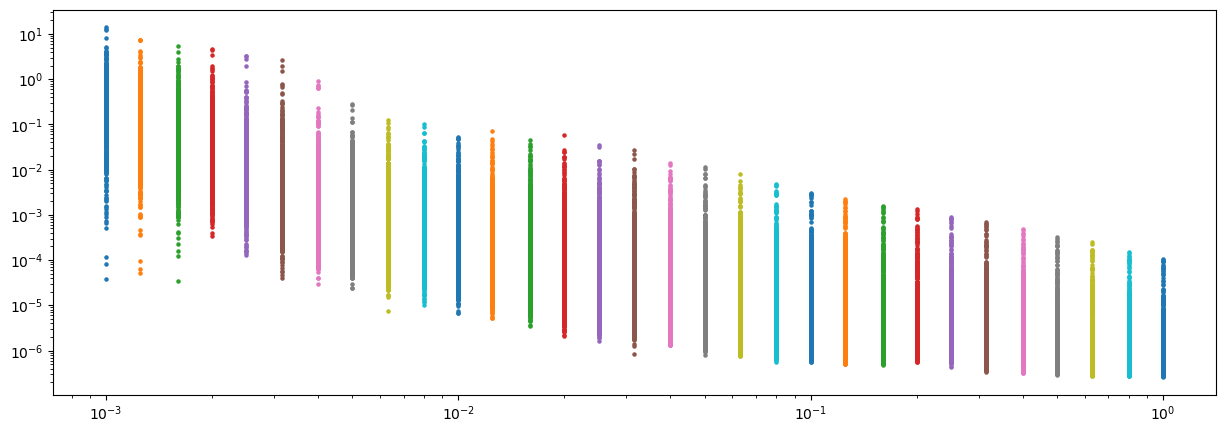

In [21]:
def __get_band_means(freq, data, f_center, f_upper, f_lower):

    psd_mean, fc, fu, fl = [], [], [], []
    for _n, (ifl, ifu) in enumerate(zip(fl_idx, fu_idx)):

        means = []
        for _psd in data:
            means.append(mean(_psd[ifl:ifu]))
        psd_mean.append(array(means))
        fc.append(f_center[_n])
        fu.append(f_upper[_n])
        fl.append(f_lower[_n])

    psd_mean = array(psd_mean)


    ## check up plot
    plt.figure(figsize=(15, 5))

    for _j, dd in enumerate(psd_mean):
        plt.scatter(ones(len(dd))*fc[_j], dd, s=5)
        plt.xscale("log")
        plt.yscale("log")

    plt.show();


    ## output
    out = {}
    out['psd_means'] = psd_mean
    out['fcenter'] = array(fc)
    out['fupper'] = array(fu)
    out['flower'] = array(fl)
    out['dates'] = dates

    return out


out0 = __get_band_means(ff, dat, f_center, f_upper, f_lower)

## Store data

In [22]:
# __store_as_pickle(out0, config['path_to_outdata']+config['station']+".pkl")

In [24]:
## create and fill data frame
df_out = DataFrame()

df_out['dates'] = out0['dates']

for _i, fc in enumerate(out0['fcenter']):
    df_out[round(fc, 5)] = out0['psd_means'][_i]

## store as pickle file
df_out.to_pickle(config['path_to_outdata']+config['station']+".pkl")

ValueError: Length of values (31) does not match length of index (744)